/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

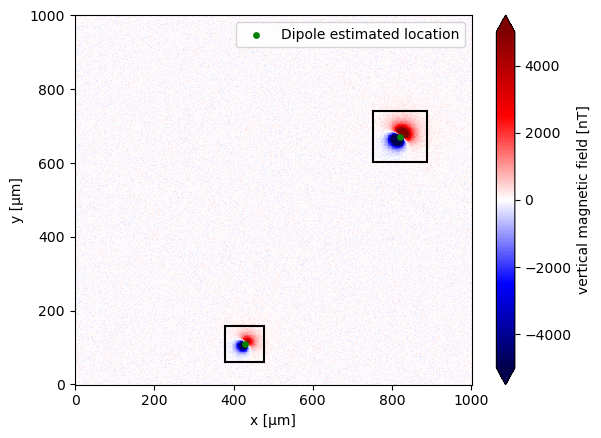

In [2]:
import ensaio
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import skimage.exposure
import xarray as xr

import magali as mg

SEED = 42
rng = np.random.default_rng(SEED)

sensor_sample_distance = 5.0
region = [0, 1000, 0, 1000]
spacing = 2.0
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5
size = 2

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=SEED,
)

dipoles_amplitude = abs(rng.normal(0, 100, size)) * 1.0e-14
dipole_coordinates = (
    rng.integers(30, 950, size),
    rng.integers(30, 950, size),
    rng.integers(-10, -1, size),
)

dipole_moments = hm.magnetic_angles_to_vec(
    inclination=directions_inclination,
    declination=directions_declination,
    intensity=dipoles_amplitude,
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
noise_std_dev = 100
data.values += rng.normal(loc=0, scale=noise_std_dev, size=data.shape)

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[20, 150],
    detection_threshold=0.2,
    border_exclusion=2,
)

data_updated, euler_locations_, dipole_moments_, r2_values = (
    mg.iterative_nonlinear_inversion(
        data_up,
        bounding_boxes,
        height_difference=height_difference,
        copy_data=True,
    )
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(euler_locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location",
)
plt.legend()
plt.show()

In [3]:
dipole_coordinates

(array([428, 819]), array([109, 671]), array([ -9, -10]))

In [5]:
euler_locations_

[array([427.95875783, 109.01600238,  -8.74080318]),
 array([819.00354554, 670.99399332,   5.71432648])]

In [6]:
dipole_locations = []
for i in range(len(dipole_coordinates[0])):
    dipole_locations.append(
        np.array(
            [
                dipole_coordinates[0][i],
                dipole_coordinates[1][i],
                dipole_coordinates[2][i],
            ]
        )
    )
print(dipole_locations)

[array([428, 109,  -9]), array([819, 671, -10])]


In [10]:
distances = [np.linalg.norm(a - b) for a, b in zip(dipole_locations, euler_locations_)]
distances

[np.float64(0.2629448323568683), np.float64(15.71432802710971)]

In [11]:
import choclo
import harmonica as hm
import numba
import numpy as np
import verde as vd


def iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=5.0,
    copy_data=True,
):
    """
    Perform iterative Euler and nonlinear dipole inversion over bounding boxes.

    Parameters
    ----------
    data_up : xarray.DataArray
        Upward-continued magnetic data with coordinates "x", "y", and "z".
        This is typically obtained after upward continuation of observed
        magnetic data.

    bounding_boxes : list of lists or arrays
        Bounding boxes of detected anomalies in data coordinates.
        Each bounding box is defined as [x_min, x_max, y_min, y_max].

    height_difference : float, optional
        Height increment (in µm) used for upward continuation after each
        iteration (default is 5.0). Increasing this value smooths the field
        more rapidly between iterations.

    copy_data : bool, optional
        If True (default), operates on a deep copy of the input data to avoid
        modifying the original array. If False, modifications will be applied
        directly to the provided data array.

    Returns
    -------
    data_updated : xarray.DataArray
        Magnetic data after iterative dipole removal and upward continuation.

    locations_ : list of tuples
        Estimated (x, y, z) coordinates of the dipole sources identified during
        the inversion.

    dipole_moments_ : list of arrays
        Estimated magnetic dipole moments (in A·m²) corresponding to each
        bounding box.

    r2_values : list of floats
        Coefficient of determination (R²) for each nonlinear inversion fit,
        indicating model quality.
    """
    locations_ = []
    dipole_moments_ = []
    r2_values = []

    table = vd.grid_to_table(data_up)
    global_coordinates = (table.x.values, table.y.values, table.z.values)

    data_updated = data_up.copy(deep=True) if copy_data else data_up

    for box in bounding_boxes:
        anomaly = data_updated.sel(x=slice(*box[:2]), y=slice(*box[2:]))

        dx, dy, dz, tga = mg.gradient(anomaly)
        anomaly["dx"], anomaly["dy"], anomaly["dz"], anomaly["tga"] = dx, dy, dz, tga

        table = vd.grid_to_table(anomaly)

        euler = hm.EulerDeconvolution(3)
        euler.fit((table.x, table.y, table.z), (table.bz, table.dx, table.dy, table.dz))

        bz_corrected = table.bz.values - euler.base_level_
        coordinates = (table.x.values, table.y.values, table.z.values)

        model_nl = mg.NonlinearMagneticDipoleBz(
            initial_location=euler.location_, max_iter=1000
        )
        model_nl.fit(coordinates, bz_corrected)

        locations_.append(model_nl.location_)
        dipole_moments_.append(model_nl.dipole_moment_)
        r2_values.append(model_nl.r2_)

        modeled_bz = mg.dipole_bz(
            global_coordinates, model_nl.location_, model_nl.dipole_moment_
        )
        for x_val, y_val, bz_val in zip(table.x.values, table.y.values, modeled_bz):
            data_updated.loc[{"x": x_val, "y": y_val}] -= bz_val

        data_updated = (
            hm.upward_continuation(data_updated, height_difference)
            .assign_attrs(data_updated.attrs)
            .assign_coords(x=data_updated.x, y=data_updated.y)
            .assign_coords(z=data_updated.z + height_difference)
            .rename("bz")
        )
        dx, dy, dz, tga = mg.gradient(data_updated)
        data_updated["dx"] = dx
        data_updated["dy"] = dy
        data_updated["dz"] = dz
        data_updated["tga"] = tga

    return data_updated, locations_, dipole_moments_, r2_values

/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

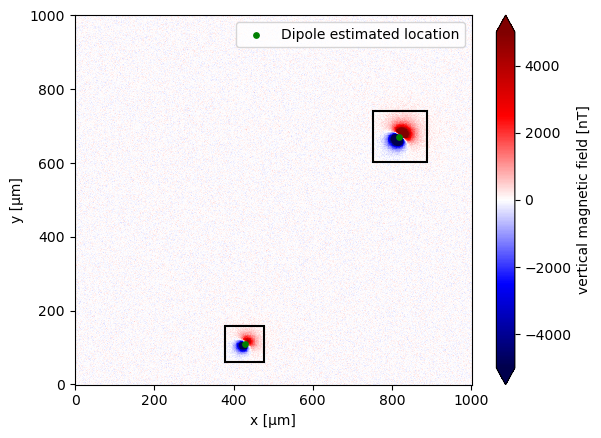

In [12]:
data_updated, locations_, dipole_moments_, r2_values = iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location",
)
plt.legend()
plt.show()

In [14]:
distances = [np.linalg.norm(a - b) for a, b in zip(dipole_locations, locations_)]
distances

[np.float64(0.06372397538531584), np.float64(0.029082464217514512)]

In [16]:
locations_

[array([427.95760466, 109.04485572,  -8.98414616]),
 array([818.98017506, 670.97877068,  -9.99855874])]

/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

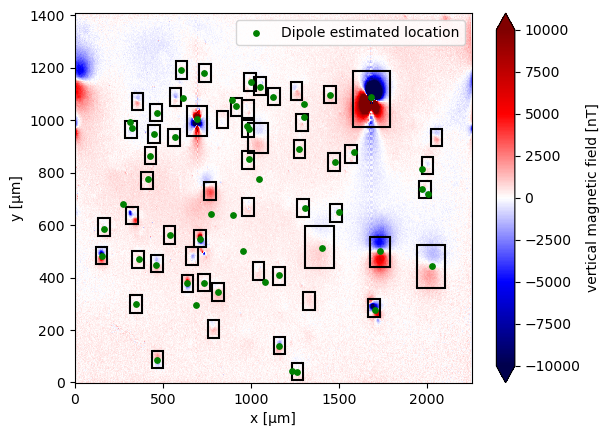

In [17]:
fname = ensaio.fetch_morroco_speleothem_qdm(version=1, file_format="matlab")
data = mg.read_qdm_harvard(fname)

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[20, 150],
    detection_threshold=0.02,
    border_exclusion=2,
)

data_updated, locations_, dipole_moments_, r2_values = iterative_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location"
)
plt.legend()
plt.show()

/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

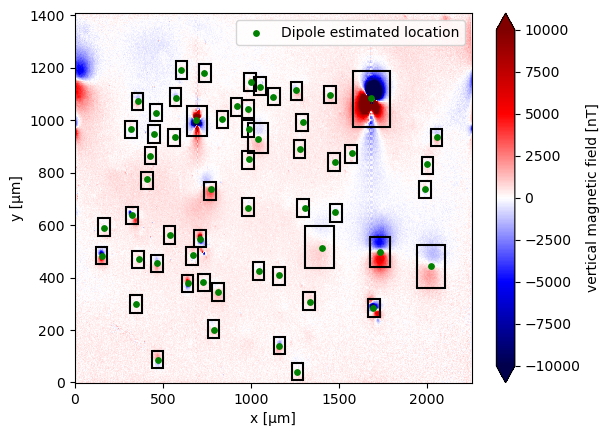

In [19]:
data_updated, euler_locations_, dipole_moments_, r2_values = mg.iterative_nonlinear_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(euler_locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location"
)
plt.legend()
plt.show()